# Importing Data

In [ ]:
import pandas as pd

# Read data from CSV
data = pd.read_csv('output_df_pik3ca_1.csv')

# Assuming the CSV has columns 'SMILES' and 'pIC50'
smiles = data['smiles'].values
pIC50 = data['pIC50'].values


# FIltering length of SMILES

In [ ]:
import pandas as pd

# Assuming your dataframe is named 'data' and the column containing SMILES is named 'smiles'

# Sample DataFrame
# data = pd.DataFrame({'smiles': ['C'*100, 'C'*120, 'C'*90]})

# Filtering rows based on SMILES string length and replacing original dataframe
data = data[data['smiles'].apply(len) <= 110]

# Reset index after filtering
data.reset_index(drop=True, inplace=True)

# Print or use the filtered dataframe as required
print(data)


# Variational Autoencoder Model

## Preprocessing the data for the VAE model




Import the necessary libraries.

Load your dataset, which includes SMILES strings and corresponding pIC50 values.

Tokenize, pad, and encode the SMILES strings.

Normalize the pIC50 values to have zero mean and unit variance.

In [ ]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
smiles_data = data["smiles"]
pic50_data = data["pIC50"]

In [ ]:
# Define a dictionary to map two-letter symbols and elements to single characters
element_mapping = {
    "Ac": "a",
    "Ag": "b",
    "Al": "l",
    "Au": "e",
    "Ba": "f",
    "Be": "g",
    "Bi": "h",
    "Bk": "i",
    "Br": "j",
    "Ca": "k",
    "Ce": "m",
    "Cl": "n",
    "Cr": "p",
    "Cu": "r",
    "Fe": "q",
    "Ga": "t",
    "Gd": "u",
    "Ge": "v",
    "Hf": "x",
    "In": "A",
    "Kr": ":",
    "La": ";",
    "Li": "D",
    "Lu": "E",
    "Mg": "d",
    "Mn": "G",
    "Mo": ",",
    "Nb": "!",
    "Nd": "J",
    "Ni": "?",
    "Pd": "*",
    "Pt": "&",
    "Ra": "P",
    "Rb": "Q",
    "Re": "R",
    "Ru": "~",
    "Sb": "T",
    "Se": "{",
    "Si": "V",
    "Sm": "}",
    "Sr": "X",
    "Ta": "z",
    "Tc": "Z",
    "Te": "L",
    "Ti": "_",
    "Tl": "^",
    "Zn": "₱",
    "Zr": "€",
    "@@": "$"
}

In [ ]:
# Replace using the dictionary
smiles_data = ["".join(element_mapping.get(smiles[i:i+2], smiles[i]) for i in range(0, len(smiles), 2)) for smiles in smiles_data.tolist()]

In [ ]:
# Tokenize the SMILES strings and replace using the dictionary
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(smiles_data)
sequences = tokenizer.texts_to_sequences(smiles_data)

In [ ]:
# Number of unique tokens
num_tokens = len(tokenizer.word_index)

# Maximum token length
max_token_length = max(len(seq) for seq in sequences)

print("Number of unique tokens:", num_tokens)
print("Maximum token length:", max_token_length)

In [ ]:
# Pad sequences to the same length
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

In [ ]:
# Convert to numpy arrays
X = padded_sequences
y = np.array(pic50_data)  # Assuming pic50_data is already a numpy arra

In [ ]:
# Normalize pIC50 values using standard scaling (z-score normalization)
pic50_scaler = StandardScaler()
y = pic50_scaler.fit_transform(y.reshape(-1, 1)).flatten()

In [ ]:
# Split your data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Build the VAE model

In [ ]:
def compute_reconstruction_accuracy(inputs, outputs):
    # Ensure the data types are the same
    inputs = tf.cast(inputs, tf.int64)
    # Find the indices of the maximum values along the last dimension
    predicted_sequences = tf.argmax(outputs, axis=-1, output_type=tf.int64)
    # Compare predicted sequences with the original inputs
    matches = tf.cast(tf.equal(inputs, predicted_sequences), tf.float32)
    # Calculate the accuracy
    accuracy = tf.reduce_mean(matches)
    return accuracy

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Embedding, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# Hyperparameters
latent_dim = 32
input_dim = X_train.shape[1]
vocab_size = len(tokenizer.word_index) + 1
epochs = 200
batch_size = 32

# Encoder
inputs = Input(shape=(input_dim,))
x = Embedding(input_dim=vocab_size, output_dim=64, input_length=input_dim)(inputs)
x = LSTM(256)(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.0)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder
decoder_inputs = Input(shape=(latent_dim,))
x = RepeatVector(input_dim)(decoder_inputs)
x = LSTM(256, return_sequences=True)(x)
outputs = TimeDistributed(Dense(vocab_size, activation='softmax'))(x)

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(decoder_inputs, outputs, name='decoder')

# VAE Model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

# Optimizer
optimizer = Adam()

In [ ]:
# Define the loss function
def compute_loss(inputs, outputs, z_mean, z_log_var):
    reconstruction_loss = tf.reduce_mean(
        tf.reduce_sum(
            sparse_categorical_crossentropy(inputs, outputs), axis=1
        )
    )
    kl_loss = -0.5 * tf.reduce_mean(
        1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    )
    total_loss = reconstruction_loss + kl_loss
    return total_loss, reconstruction_loss, kl_loss

# Define the accuracy computation function
def compute_reconstruction_accuracy(inputs, outputs):
    inputs = tf.cast(inputs, tf.int64)
    predicted_sequences = tf.argmax(outputs, axis=-1, output_type=tf.int64)
    matches = tf.cast(tf.equal(inputs, predicted_sequences), tf.float32)
    accuracy = tf.reduce_mean(matches)
    return accuracy

# Custom training loop
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, X_train)).shuffle(buffer_size=1024).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, X_test)).batch(batch_size)

# Compile the model
optimizer = tf.keras.optimizers.Adam()
vae.compile(optimizer=optimizer, loss=sparse_categorical_crossentropy, metrics=['accuracy'])

In [ ]:
# Initialize lists to store training and validation loss values
train_losses = []
val_losses = []

# Train the model
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    total_loss = 0
    total_reconstruction_loss = 0
    total_accuracy = 0
    steps = 0

    # Training loop
    for x_batch_train, y_batch_train in train_dataset:
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(x_batch_train, training=True)
            reconstructions = decoder(z, training=True)
            loss, reconstruction_loss, kl_loss = compute_loss(x_batch_train, reconstructions, z_mean, z_log_var)

        gradients = tape.gradient(loss, vae.trainable_variables)
        optimizer.apply_gradients(zip(gradients, vae.trainable_variables))

        accuracy = compute_reconstruction_accuracy(x_batch_train, reconstructions)

        total_loss += loss
        total_reconstruction_loss += reconstruction_loss
        total_accuracy += accuracy
        steps += 1

    mean_loss = total_loss / steps
    mean_reconstruction_loss = total_reconstruction_loss / steps
    mean_accuracy = total_accuracy / steps

    # Append the mean training loss to the list
    train_losses.append(mean_loss.numpy())  # <-- New line

    # Validation loop
    val_loss = 0
    val_accuracy = 0
    val_steps = 0
    for x_batch_val, y_batch_val in test_dataset:
        z_mean_val, z_log_var_val, z_val = encoder(x_batch_val, training=False)
        reconstructions_val = decoder(z_val, training=False)
        loss_val, _, _ = compute_loss(x_batch_val, reconstructions_val, z_mean_val, z_log_var_val)

        accuracy_val = compute_reconstruction_accuracy(x_batch_val, reconstructions_val)

        val_loss += loss_val
        val_accuracy += accuracy_val
        val_steps += 1

    mean_val_loss = val_loss / val_steps
    mean_val_accuracy = val_accuracy / val_steps

    # Append the mean validation loss to the list
    val_losses.append(mean_val_loss.numpy())  # <-- New line

    print(f"  Training Loss: {mean_loss:.4f}, Reconstruction Loss: {mean_reconstruction_loss:.4f}, Accuracy: {mean_accuracy:.4f}")
    print(f"  Validation Loss: {mean_val_loss:.4f}, Validation Accuracy: {mean_val_accuracy:.4f}")


## Evaluate the VAE model

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation loss over epochs
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model
loss, accuracy = vae.evaluate(test_dataset)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

In [ ]:
# Save the entire VAE model
vae.save('vae_model.h5')

# Save the encoder and decoder models separately
encoder.save('encoder_model.h5')
decoder.save('decoder_model.h5')

In [ ]:
from google.colab import drive
from tensorflow.keras.models import load_model

# Mount Google Drive
drive.mount('/content/drive')

# Define the paths
vae_path = '/content/drive/Shared drives/THESIS LET\'S GOOO/Colab Notebooks/Erin - sample run/Variational Autoencoder/Trained Models/vae_model[adjusted plots]_1.h5'
encoder_path = '/content/drive/Shared drives/THESIS LET\'S GOOO/Colab Notebooks/Erin - sample run/Variational Autoencoder/Trained Models/encoder_model[adjusted plots]_1.h5'
decoder_path = '/content/drive/Shared drives/THESIS LET\'S GOOO/Colab Notebooks/Erin - sample run/Variational Autoencoder/Trained Models/decoder_model[adjusted plots]_1.h5'

# Assuming your VAE, encoder, and decoder models are defined as follows
# vae = Model(inputs, outputs) # Your VAE model
# encoder = Model(inputs, encoder_outputs) # Your encoder model
# decoder = Model(decoder_inputs, decoder_outputs) # Your decoder model

# Save the entire VAE model
vae.save(vae_path)

# Save the encoder and decoder models separately
encoder.save(encoder_path)

decoder.save(decoder_path)

# Regression Model

## Preprocessing the data for the Regression model







Import the necessary libraries.

Load your dataset, which includes SMILES strings and corresponding pIC50 values.

Tokenize, pad, and encode the SMILES strings.

Normalize the pIC50 values to have zero mean and unit variance.

In [ ]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
smiles_data = data["smiles"]
pic50_data = data["pIC50"]

In [ ]:
# Define a dictionary to map two-letter symbols and elements to single characters
element_mapping = {
    "Ac": "a",
    "Ag": "b",
    "Al": "l",
    "Au": "e",
    "Ba": "f",
    "Be": "g",
    "Bi": "h",
    "Bk": "i",
    "Br": "j",
    "Ca": "k",
    "Ce": "m",
    "Cl": "n",
    "Cr": "p",
    "Cu": "r",
    "Fe": "q",
    "Ga": "t",
    "Gd": "u",
    "Ge": "v",
    "Hf": "x",
    "In": "A",
    "Kr": ":",
    "La": ";",
    "Li": "D",
    "Lu": "E",
    "Mg": "d",
    "Mn": "G",
    "Mo": ",",
    "Nb": "!",
    "Nd": "J",
    "Ni": "?",
    "Pd": "*",
    "Pt": "&",
    "Ra": "P",
    "Rb": "Q",
    "Re": "R",
    "Ru": "~",
    "Sb": "T",
    "Se": "{",
    "Si": "V",
    "Sm": "}",
    "Sr": "X",
    "Ta": "z",
    "Tc": "Z",
    "Te": "L",
    "Ti": "_",
    "Tl": "^",
    "Zn": "₱",
    "Zr": "€",
    "@@": "$"
}

In [ ]:
# Replace using the dictionary
smiles_data = ["".join(element_mapping.get(smiles[i:i+2], smiles[i]) for i in range(0, len(smiles), 2)) for smiles in smiles_data.tolist()]

In [ ]:
# Tokenize the SMILES strings and replace using the dictionary
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(smiles_data)
sequences = tokenizer.texts_to_sequences(smiles_data)

In [ ]:
# Pad sequences to the same length
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

In [ ]:
max_length

55

In [ ]:
# Convert to numpy arrays
X = padded_sequences
y = np.array(pic50_data)  # Assuming pic50_data is already a numpy arra

In [ ]:
X.shape

(4782, 55)

In [ ]:
y.shape

(4782,)

In [ ]:
# Normalize pIC50 values using standard scaling (z-score normalization)
pic50_scaler = StandardScaler()
y = pic50_scaler.fit_transform(y.reshape(-1, 1)).flatten()

In [ ]:
# Split your data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Split X_train and y_train into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# X_train, y_train: Training data
# X_val, y_val: Validation data
# X_test, y_test: Test data

## Create Regression Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Create a regression model
regression_model = Sequential([
    Dense(64, activation='relu', input_shape=(latent_dim,)),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer with one neuron for pIC50 prediction
])

# Compile the model
regression_model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
regression_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4225 (16.50 KB)
Trainable params: 4225 (16.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Train the Regression Model

Epoch 1/100
87/87 [==============================] - 21s 216ms/step - loss: 0.9283 - mae: 0.7608 - val_loss: 0.9846 - val_mae: 0.7866
Epoch 2/100
87/87 [==============================] - 19s 215ms/step - loss: 0.8962 - mae: 0.7523 - val_loss: 0.9891 - val_mae: 0.7868
Epoch 3/100
87/87 [==============================] - 19s 213ms/step - loss: 0.8861 - mae: 0.7464 - val_loss: 0.9666 - val_mae: 0.7768
Epoch 4/100
87/87 [==============================] - 18s 208ms/step - loss: 0.8461 - mae: 0.7309 - val_loss: 0.9065 - val_mae: 0.7456
Epoch 5/100
87/87 [==============================] - 18s 205ms/step - loss: 0.8035 - mae: 0.7111 - val_loss: 0.8462 - val_mae: 0.7195
Epoch 6/100
87/87 [==============================] - 18s 206ms/step - loss: 0.7486 - mae: 0.6811 - val_loss: 0.8529 - val_mae: 0.7230
Epoch 7/100
87/87 [==============================] - 18s 204ms/step - loss: 0.7227 - mae: 0.6658 - val_loss: 0.8145 - val_mae: 0.7052
Epoch 8/100
87/87 [==============================] - 20s 225ms

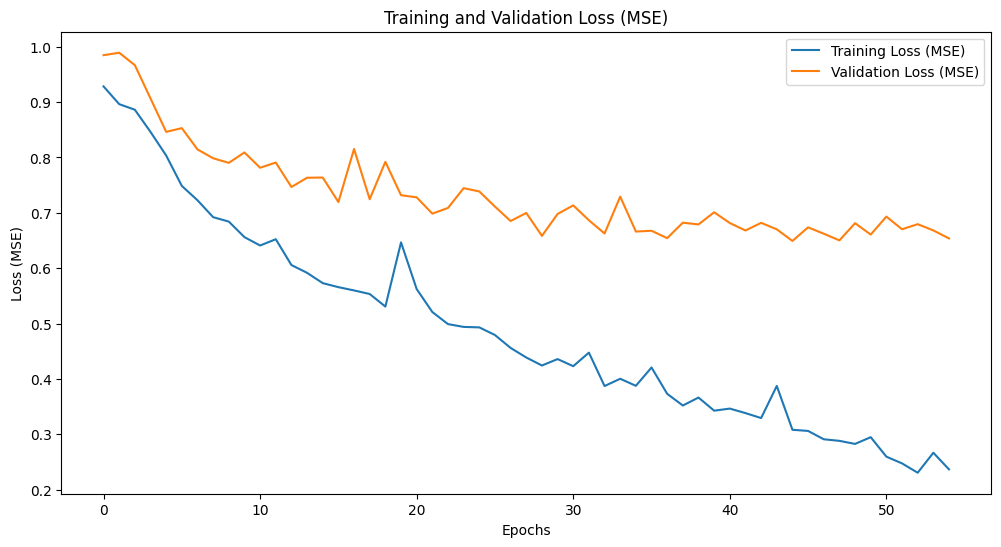

30/30 [==============================] - 2s 68ms/step


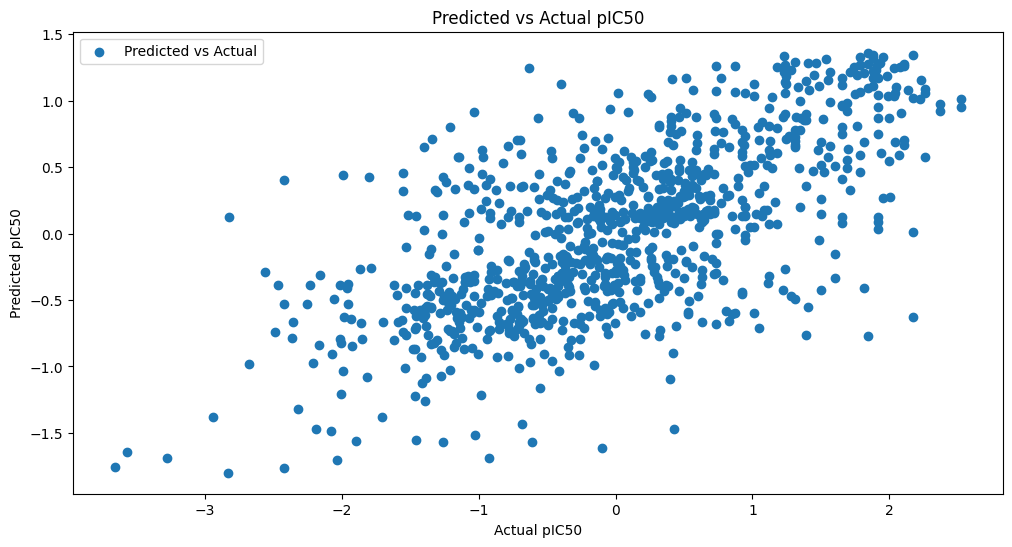

In [ ]:
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Assuming 'encoder' is your encoder model from the VAE

# Extract the encoder model up to the LSTM layer
encoder_lstm_output = encoder.get_layer('lstm').output
encoder_model = Model(inputs=encoder.input, outputs=encoder_lstm_output)

# Define the regression model
regression_model = Sequential([
    encoder_model,  # Encoder LSTM output as input
    Dense(64, activation='relu'),
    Dropout(0.5),  # Add dropout for regularization
    Dense(32, activation='relu'),
    Dropout(0.5),  # Add dropout for regularization
    Dense(1)  # Output layer for regression
])

# Compile the regression model with MSE loss and MAE metric
regression_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the regression model with early stopping
history = regression_model.fit(
    x=X_train,  # Input data (encoder outputs)
    y=y_train,  # Target data (pIC50)
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

# Evaluate the model
loss, mae = regression_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {loss:.4f}")
print(f"Test MAE: {mae:.4f}")

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss (MSE)')
plt.legend()
plt.show()


# Predict on the test set
y_pred = regression_model.predict(X_test)

# Plot predicted vs actual values
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, label='Predicted vs Actual')
plt.xlabel('Actual pIC50')
plt.ylabel('Predicted pIC50')
plt.title('Predicted vs Actual pIC50')
plt.legend()
plt.show()



In [ ]:
# Evaluate the model
loss, mae = regression_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {loss:.4f}")
print(f"Test MAE: {mae:.4f}")

Test Loss (MSE): 0.6316
Test MAE: 0.6118


#Evaluate Model

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss (MSE)')
plt.legend()
plt.show()

# Plot training & validation MAE values
plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()
plt.show()

# Predict on the test set
y_pred = regression_model.predict(X_test)

# Plot predicted vs actual values
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, label='Predicted vs Actual')
plt.xlabel('Actual pIC50')
plt.ylabel('Predicted pIC50')
plt.title('Predicted vs Actual pIC50')
plt.legend()
plt.show()

#Save Regression Model

In [ ]:
# Assuming you have X_train_encoded (encoded SMILES) with shape (5201, 166, 35)
# and pic50 values as y_train with shape (5201, 1)

# Compile the regression model
regression_model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
from tensorflow.keras.models import save_model

# Assuming you have already trained and have the regression_model object

# Save the trained regression model
save_model(regression_model, 'regression_model.h5')

# Cross-Validation w/ Filtering >110

In [ ]:
import pandas as pd

# Read data from CSV
data = pd.read_csv('output_df_pik3ca_1.csv')

In [ ]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

smiles_data = data["smiles"]
pic50_data = data["pIC50"]

In [ ]:
# Define a dictionary to map two-letter symbols and elements to single characters
element_mapping = {
    "Ac": "a",
    "Ag": "b",
    "Al": "l",
    "Au": "e",
    "Ba": "f",
    "Be": "g",
    "Bi": "h",
    "Bk": "i",
    "Br": "j",
    "Ca": "k",
    "Ce": "m",
    "Cl": "n",
    "Cr": "p",
    "Cu": "r",
    "Fe": "q",
    "Ga": "t",
    "Gd": "u",
    "Ge": "v",
    "Hf": "x",
    "In": "A",
    "Kr": ":",
    "La": ";",
    "Li": "D",
    "Lu": "E",
    "Mg": "d",
    "Mn": "G",
    "Mo": ",",
    "Nb": "!",
    "Nd": "J",
    "Ni": "?",
    "Pd": "*",
    "Pt": "&",
    "Ra": "P",
    "Rb": "Q",
    "Re": "R",
    "Ru": "~",
    "Sb": "T",
    "Se": "{",
    "Si": "V",
    "Sm": "}",
    "Sr": "X",
    "Ta": "z",
    "Tc": "Z",
    "Te": "L",
    "Ti": "_",
    "Tl": "^",
    "Zn": "₱",
    "Zr": "€",
    "@@": "$"
}

In [ ]:
# Replace using the dictionary
smiles_data = ["".join(element_mapping.get(smiles[i:i+2], smiles[i]) for i in range(0, len(smiles), 2)) for smiles in smiles_data.tolist()]

In [ ]:
# Tokenize the SMILES strings and replace using the dictionary
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(smiles_data)
sequences = tokenizer.texts_to_sequences(smiles_data)

In [ ]:
# Pad sequences to the same length
max_length = 55
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

In [ ]:
# Convert to numpy arrays
X = padded_sequences
y = np.array(pic50_data)  # Assuming pic50_data is already a numpy arra

In [ ]:
# Normalize pIC50 values using standard scaling (z-score normalization)
pic50_scaler = StandardScaler()
y = pic50_scaler.fit_transform(y.reshape(-1, 1)).flatten()

In [ ]:
# Normalize pIC50 values using standard scaling (z-score normalization)
pic50_scaler = StandardScaler()
y = pic50_scaler.fit_transform(y.reshape(-1, 1)).flatten()

In [ ]:
# Split your data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Split X_train and y_train into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# X_train, y_train: Training data
# X_val, y_val: Validation data
# X_test, y_test: Test data

In [ ]:
print(regression_model.summary ())

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import tensorflow as tf

# Load pre-trained regression model
regressor = tf.keras.models.load_model('regression_model.h5')

# Filter out SMILES data with length greater than 110
max_smiles_length = 110
X_train_filtered = np.array([smiles for smiles in X_train if len(smiles) <= max_smiles_length])
y_train_filtered = np.array([y for smiles, y in zip(X_train, y_train) if len(smiles) <= max_smiles_length])

n_splits = 5
kf = KFold(n_splits=n_splits)

mse_scores = []
mae_scores = []

for train_index, val_index in kf.split(X_train_filtered):
    X_train_fold, X_val_fold = X_train_filtered[train_index], X_train_filtered[val_index]
    y_train_fold, y_val_fold = y_train_filtered[train_index], y_train_filtered[val_index]

    # Predict on validation fold using pre-trained regression model
    y_pred = regressor.predict(X_val_fold)

    # Calculate mean squared error
    mse = mean_squared_error(y_val_fold, y_pred)
    mse_scores.append(mse)

    # Calculate mean absolute error
    mae = mean_absolute_error(y_val_fold, y_pred)
    mae_scores.append(mae)

print("Cross-validated MSE: ", np.mean(mse_scores))
print("Cross-validated MAE: ", np.mean(mae_scores))


#Use Saved Autoencoder to generate fingerprints on Drugbank data

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Read Drugbank data from CSV
data_drugbank = pd.read_csv('no_surplus_tokens_drugbank.csv')

In [ ]:
import pandas as pd

# Assuming your dataframe is named 'data' and the column containing SMILES is named 'smiles'

# Sample DataFrame
# data = pd.DataFrame({'smiles': ['C'*100, 'C'*120, 'C'*90]})

# Filtering rows based on SMILES string length and replacing original dataframe
data_drugbank = data_drugbank[data_drugbank['smiles'].apply(len) <= 110]

# Reset index after filtering
data_drugbank.reset_index(drop=True, inplace=True)

# Print or use the filtered dataframe as required
print(data_drugbank)


In [ ]:
smiles_data = data_drugbank["smiles"]
pic50_data = data_drugbank["pIC50"]

In [ ]:
# Define a dictionary to map two-letter symbols and elements to single characters
element_mapping = {
    "Ac": "a",
    "Ag": "b",
    "Al": "l",
    "Au": "e",
    "Ba": "f",
    "Be": "g",
    "Bi": "h",
    "Bk": "i",
    "Br": "j",
    "Ca": "k",
    "Ce": "m",
    "Cl": "n",
    "Cr": "p",
    "Cu": "r",
    "Fe": "q",
    "Ga": "t",
    "Gd": "u",
    "Ge": "v",
    "Hf": "x",
    "In": "A",
    "Kr": ":",
    "La": ";",
    "Li": "D",
    "Lu": "E",
    "Mg": "d",
    "Mn": "G",
    "Mo": ",",
    "Nb": "!",
    "Nd": "J",
    "Ni": "?",
    "Pd": "*",
    "Pt": "&",
    "Ra": "P",
    "Rb": "Q",
    "Re": "R",
    "Ru": "~",
    "Sb": "T",
    "Se": "{",
    "Si": "V",
    "Sm": "}",
    "Sr": "X",
    "Ta": "z",
    "Tc": "Z",
    "Te": "L",
    "Ti": "_",
    "Tl": "^",
    "Zn": "₱",
    "Zr": "€",
    "@@": "$"
}

In [ ]:
# Replace using the dictionary
smiles_data = ["".join(element_mapping.get(smiles[i:i+2], smiles[i]) for i in range(0, len(smiles), 2)) for smiles in smiles_data.tolist()]

In [ ]:
# Tokenize the SMILES strings and replace using the dictionary
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(smiles_data)
sequences = tokenizer.texts_to_sequences(smiles_data)

In [ ]:
tokenizer.word_index

In [ ]:
# Pad sequences to the same length
max_length = 55
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

In [ ]:
# Convert to numpy arrays
X = padded_sequences
y = np.array(pic50_data)  # Assuming pic50_data is already a numpy arra

In [ ]:
X.shape

In [ ]:
y.shape

In [ ]:
# Normalize pIC50 values using standard scaling (z-score normalization)
pic50_scaler = StandardScaler()
y = pic50_scaler.fit_transform(y.reshape(-1, 1)).flatten()

In [ ]:
from tensorflow.keras.models import load_model
# Load the pretrained regression model
regression_model = load_model('regression_model(100_epochs).h5')


In [ ]:
print(regression_model.summary())

In [ ]:
# Use the encoded representations as input to the regression model for prediction
predictions = regression_model.predict(X)


172/172 [==============================] - 9s 52ms/step


In [ ]:
import matplotlib.pyplot as plt

# Assuming predictions is a numpy array containing the predicted values
plt.plot(predictions, label='Predicted Values')
plt.xlabel('DrugBank Smiles')
plt.ylabel('Predicted Value')
plt.title('Regression Model Predictions')
plt.legend()
plt.show()


In [ ]:
print(predictions)

In [ ]:
import pandas as pd

# Assuming 'predictions' contains the predictions generated by your regression model

# Create a DataFrame with your predictions
predictions_df = pd.DataFrame(predictions, columns=['pIC50'])

# Optionally, if you have corresponding input data or labels, you can include them in the DataFrame
# For example, if 'input_data' contains the input data used for predictions
# predictions_df['Input_Data_Column'] = input_data
# If 'actual_labels' contain the actual labels (if available)
# predictions_df['Actual_Labels'] = actual_labels

# Save the DataFrame to a CSV file
predictions_df.to_csv('regression_predictions_with_dummy_drugbank.csv', index=False)


In [ ]:
import pandas as pd

# Assuming 'predictions' contains the predictions generated by your regression model
# Assuming 'data_drugbank' contains the SMILES strings

# Create a DataFrame with your predictions
predictions_df = pd.DataFrame(predictions, columns=['pIC50'])

# Optionally, if you have corresponding input data or labels, you can include them in the DataFrame
# For example, if 'input_data' contains the input data used for predictions
# predictions_df['Input_Data_Column'] = input_data
# If 'actual_labels' contain the actual labels (if available)
# predictions_df['Actual_Labels'] = actual_labels

# Assuming both DataFrames have the same index or a unique identifier column
# Merge predictions_df with drugbank_data based on the index
merged_df = data_drugbank.merge(predictions_df, left_index=True, right_index=True)

# Save the merged DataFrame to a CSV file
merged_df.to_csv('regression_predictions_with_dummy_drugbank.csv', index=False)
